# Построение модели ARIMA для RTSI

В этой программе рассмотрим построение модели ARIMA для RTSI. Известны данные по индексу RTSI за 1998-2017 года, необходимо построить прогноз на следующие 3 года.


## Подбор ARIMA

1) Смотрим на ряд.

2) При необходимости стабилизируем дисперсию.

3) Если ряд нестационарен, подбираем порядок дифференцирования.

4) Анализируем ACF/PACF, определяем примерные p, q, P, Q

5) Обучаем модели-кандидаты, сравниваем их по AIC, выбираем победителя.

6) Смотрим на остатки полученной модели, если они плохие, пробуем что-то поменять.

### Временной ряд: 
$$y_{1},...,y_{T} ,..., y_{t} ∈ R,$$ — признак, измеренный через постоянные временные интервалы.

## Задача прогнозирования

Задача прогнозирования — найти функцию $$f_{T}:$$ 
$$y_{T+d} ≈ f_{T} (y_{T} ,...,y_{1}, d) ≡ yˆ_{T+d|T},$$
d ∈ {1,...,D}, D — горизонт прогнозирования.


## Главная особенность временных рядов

1) В классических задачах анализа данных предполагается независимость наблюдений

2) При прогнозировании временных рядов, наоборот, мы надеемся, что значения ряда в прошлом содержат информацию о его поведении в
будущем

## Компоненты временных рядов

Тренд — плавное долгосрочное изменение уровня ряда.

Сезонность — циклические изменения уровня ряда с постоянным периодом.

Цикл — изменения уровня ряда с переменным периодом (экономические циклы, периоды солнечной активности).

Ошибка — непрогнозируемая случайная компонента ряда.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Введем датасет(набор данных) состоящий из даты и значений акций, входящие в индекс

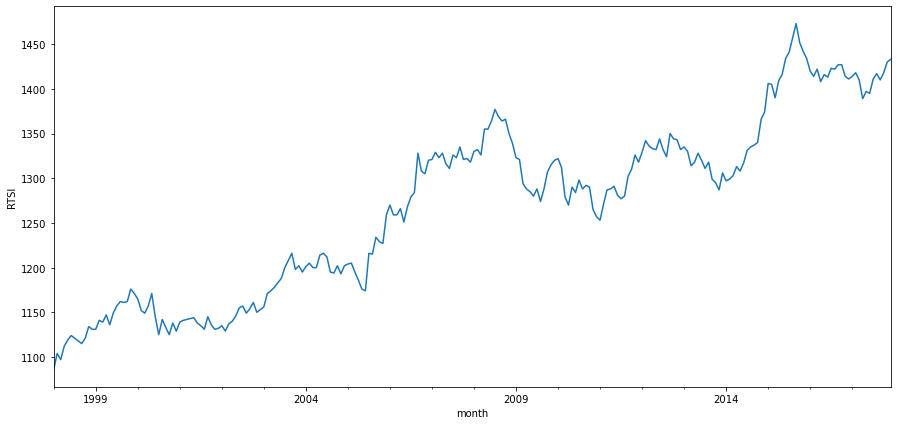

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/Practice-2020-master/VASYA4.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df.id.plot()
plt.ylabel('RTSI')
pylab.show()

Здесь определим Критерий Дики-Фуллера, проверку стационарности и STL-декомпозиция ряда:

## Стационарность — отсутствие зависимости от времени:

Стационарность:

1) Можно проверить с помощью критерия Дики-Фуллера

2) Если не выполняется, значит, модель не одинаково точна в разные периоды (необходим визуальный анализ)

Временной ряд yt является стационарным, если выполняется условие – 1‹ρ‹1;

Временной ряд yt является нестационарным и представляет собой модель со случайным трендом, если выполняется условие ρ=1;

Временной ряд yt также является нестационарным, если выполняется условие ρ›0.



p - достигаемый уровень значимости

Критерий Дики-Фуллера: p=0.722331


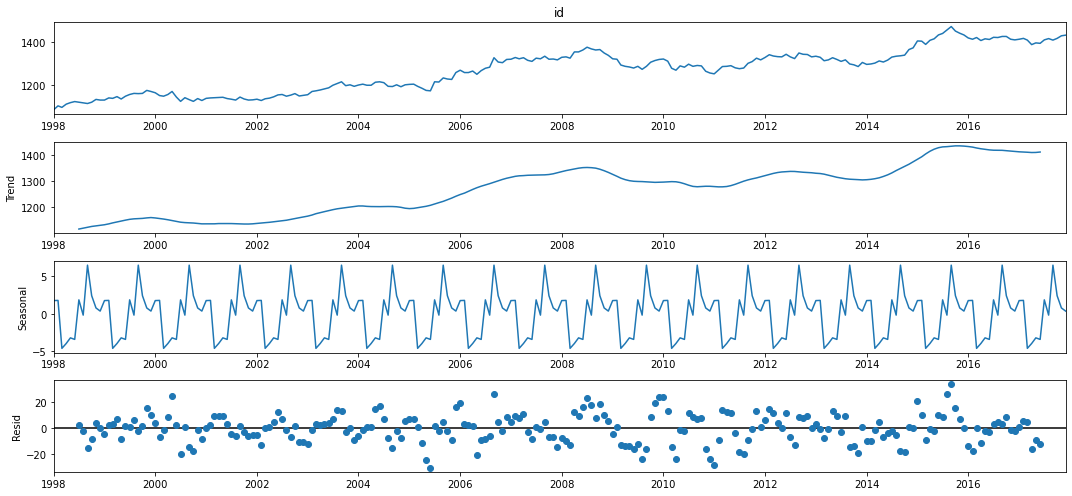

In [3]:
sm.tsa.seasonal_decompose(df.id,period=12).plot()
def invboxcox(y,lmbda): # обратная функция Бокса-Кокса
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.id)[1])

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии. Получим оптимальный параметр преобразования Бокса-Кокса:

$$y'_{t} = \ln{y_{t}}, \lambda = 0$$
$$               y'_{t} = (y^\lambda_{t}-1)/\lambda, \lambda \neq 0$$

Оптимальный параметр преобразования Бокса-Кокса: 0.735590
Критерий Дики-Фуллера: p=0.705577


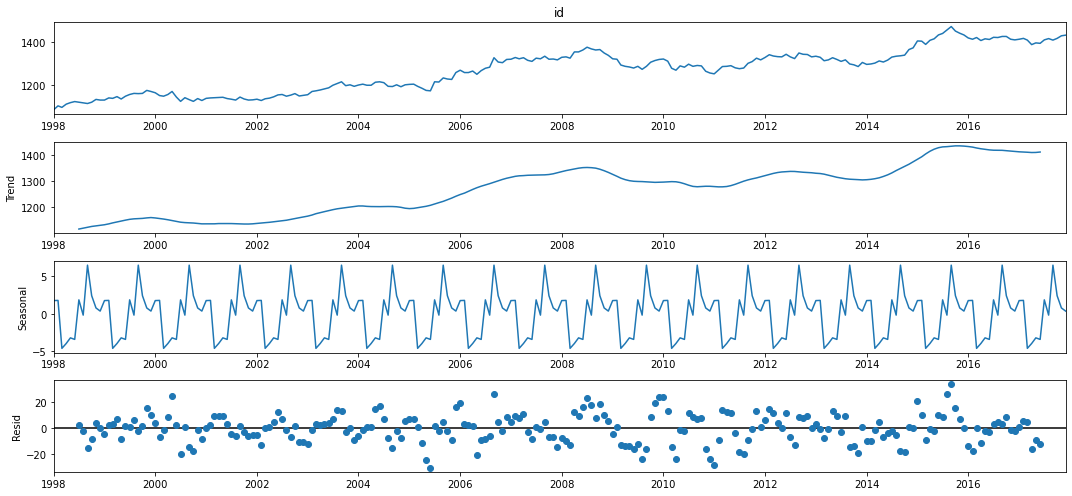

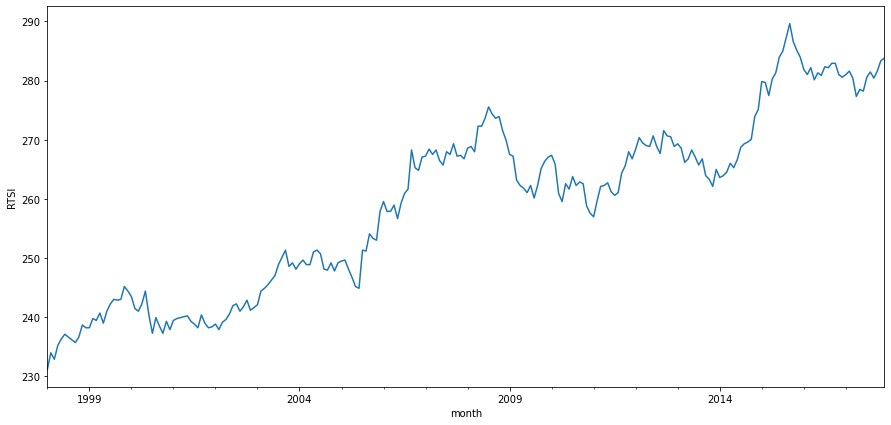

In [4]:
sm.tsa.seasonal_decompose(df.id,period=12).plot()
df['stocks'], lmbda = stats.boxcox(pd.to_numeric(df.id))
plt.figure(figsize(15,7))
df.stocks.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks)[1])


# Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

## Сезонное дифференцирование ряда

Сезонное дифференцирование ряда — переход к попарным разностям
значений в соседних сезонах:

$$y'_{t} = y_{t} - y_{t-s}$$

1) убирает сезонность

2) сезонное и обычное дифференцирование могут применяться к ряду в
любом порядке

3) если ряд имеет выраженный сезонный профиль, рекомендуется начинать с сезонного дифференцирования — после него ряд уже
может оказаться стационарным

Критерий Дики-Фуллера: p=0.027741


<Figure size 1080x720 with 0 Axes>

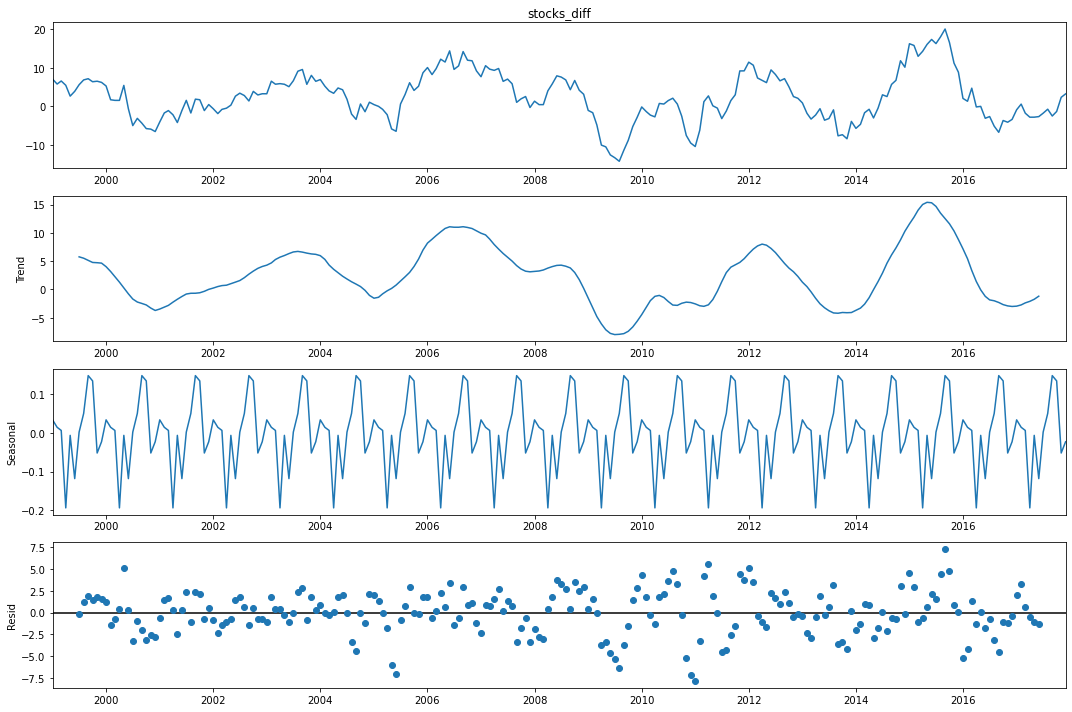

In [5]:
df['stocks_diff'] = df.stocks - df.stocks.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.stocks_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности. Попробуем добавить ещё обычное дифференцирование:

Дифференцирование ряда — переход к попарным разностям соседних
значений:

$$y'_{t} = y_{t} - y_{t-1}$$

1) позволяет стабилизировать среднее значение ряда и избавиться от тренда

2) может применяться неоднократно

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

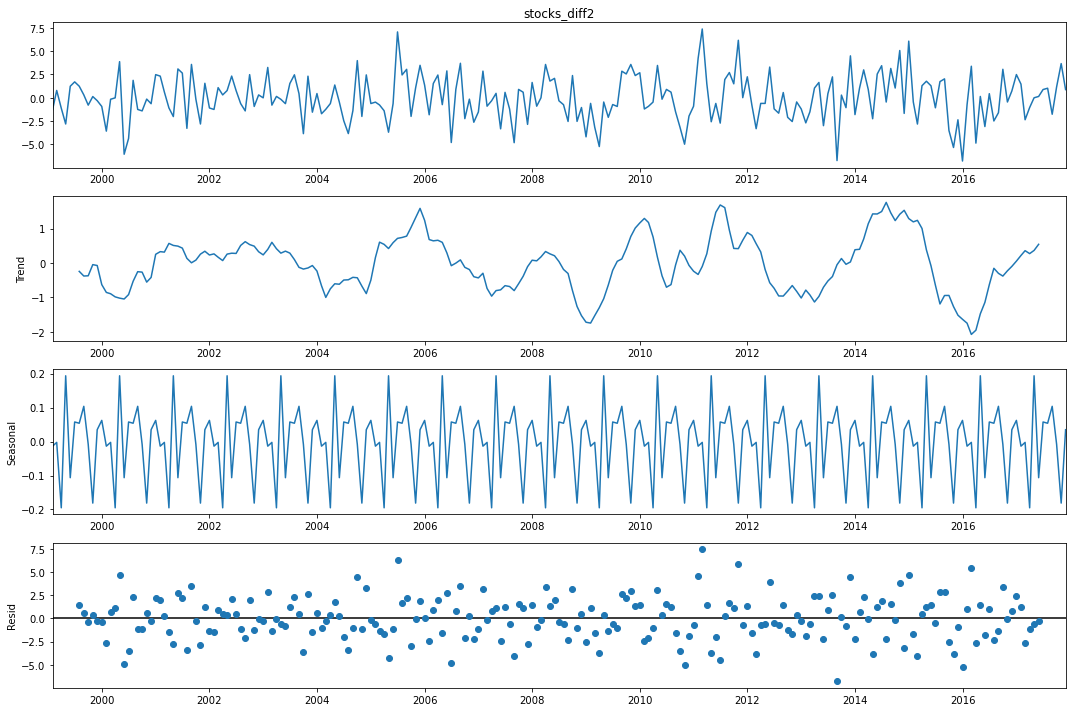

In [6]:
df['stocks_diff2'] = df.stocks_diff - df.stocks_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.stocks_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

# Подбор модели

Автокорреляция
$$r_{τ} = \frac{E ((y_{t} − E_{y})(y_{t+τ} − E_{y}))}{D_{y}}.$$
$$r_{τ} ∈ [−1, 1],$$ τ — лаг автокорреляции.
Выборочная автокорреляция:
$$r_{τ} = \frac{\sum_{t=1}^{T-τ}(y_{t} − y^-)(y_{t+τ} − y^-)}{\sum_{t=1}^{T}(y_{t} − y^-)^2}.$$




Посмотрим на ACF(подбор начальных приближений Q и q) и PACF(подбор начальных приближений P и p) полученного ряда, чтобы определить параметры

Подбор параметров:

α, φ, θ

d, D

q,Q

p, P

α, φ, θ:

1) Если все остальные параметры фиксированы, коэффициенты регрессии подбираются методом наименьших квадратов.

2) Чтобы найти коэффициенты θ, шумовая компонента предварительно оценивается с помощью остатков авторегрессии.

3) Если шум белый (независимый одинаково распределённый гауссовский), то МНК даёт оценки максимального правдоподобия.

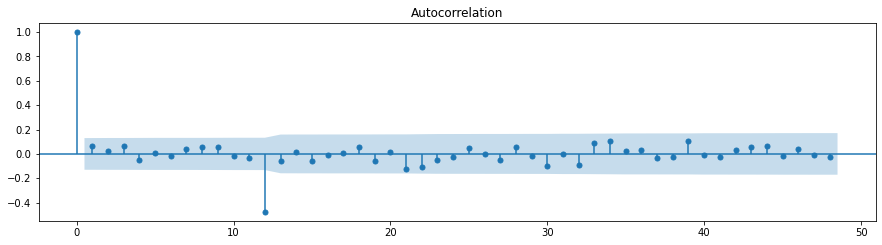

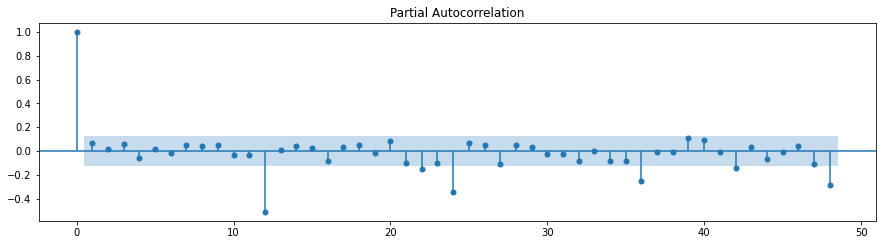

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.stocks_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.stocks_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

p, P:
    
Частичная автокорреляция — автокорреляция после снятия авторегрессии
предыдущего порядка.

P ∗ S — номер последнего сезонного лага, при котором частичная
автокорреляция значима (здесь 2).

p — номер последнего несезонного лага, при котором частичная
автокорреляция значима (здесь 2).

d, D:

1) Порядки дифференцирования подбираются так, чтобы ряд стал стационарным.

2) Ещё раз: если ряд сезонный, рекомендуется начинать с сезонного дифференцирования.

3) Чем меньше раз мы продифференцируем, тем меньше будет дисперсия итогового прогноза.

q, Q:

1) Q ∗ S — номер последнего сезонного лага, при котором автокорреляция
значима (здесь 0).

2) q — номер последнего несезонного лага, при котором автокорреляция
значима (здесь 8).

q, Q, p, P:
    
1) Гиперпараметры нельзя выбирать из принципа максимума
правдоподобия: L всегда увеличивается с их ростом.

2) Для сравнения моделей с разными q, Q, p, P можно использовать
критерий Акаике:
$$AIC = −2log{L} + 2k,$$
k = P + Q + p + q + 1 — число параметров в модели.

3) Начальные приближения можно выбрать с помощью автокорреляций.

Начальные приближения: Q=1, q=2, P=1, p=4

Переберем все значения параметров P,p,Q,q от 0 до тех приближений, которые мы подобрали по графикам автокорреляционных функций

In [8]:

ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

всего таких моделй будет 60 

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Выводим параметры, на которых модель не обучается и переходим к следующему набору:

Настроим все модели, и посчитаем для каждой значения информационного критерия Акаике(AIC) и выберем ту модель, у которой это значение будет минимальным 

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.stocks, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 57.8 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1


получаем лучшие модели 

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  926.688177
21  (1, 2, 0, 1)  928.121040
13  (1, 0, 0, 1)  928.676027
5   (0, 1, 0, 1)  928.676121
3   (0, 0, 1, 1)  928.683255


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Модель с самым лучшим результатом(то есть результат с минимальным значением критерия Акаике (AIC)) показала модель


         parameters      aic
1   (p = 0, q = 0, P = 0, Q = 1)           926.688177

Получим лучшую модель:

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               stocks   No. Observations:                  240
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -461.344
Date:                              Fri, 14 May 2021   AIC                            926.688
Time:                                      10:29:29   BIC                            933.538
Sample:                                  01-01-1998   HQIC                           929.452
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9995     11.928     -0.084      0.933     -24.379      22.380
sigma2         2.91

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


мы получили модель SARIMAX с параметрами (0, 1, 0)x(0, 1, [1], сезонный период = 12)
есть значения статистики критерия Ljung-Box (L1) (при автоматически выбранном Q):

Её остатки:

Критерий Стьюдента проверяет гипотезу несмещенности и её не отвергает с достигаемым уровнем значимости p=0.592138

Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности p=0.000000

## Остатки

Остатки — разность между фактом и прогнозом:
$$εˆ_{t} = y_{t} − yˆ_{t|t−1}$$.

Нужно проверять, обладают ли они некоторыми свойствами.

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.592138
Критерий Дики-Фуллера: p=0.000000


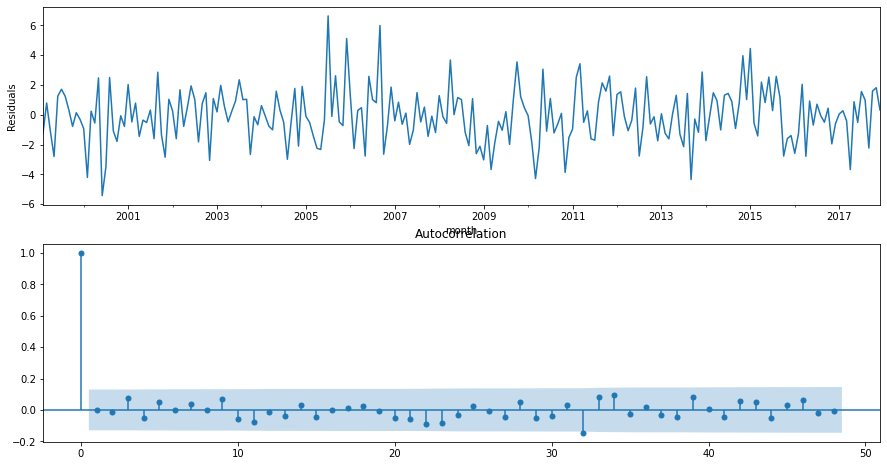

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Следовательно наша модель хороша. Посмотрим, насколько хорошо модель описывает данные:

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


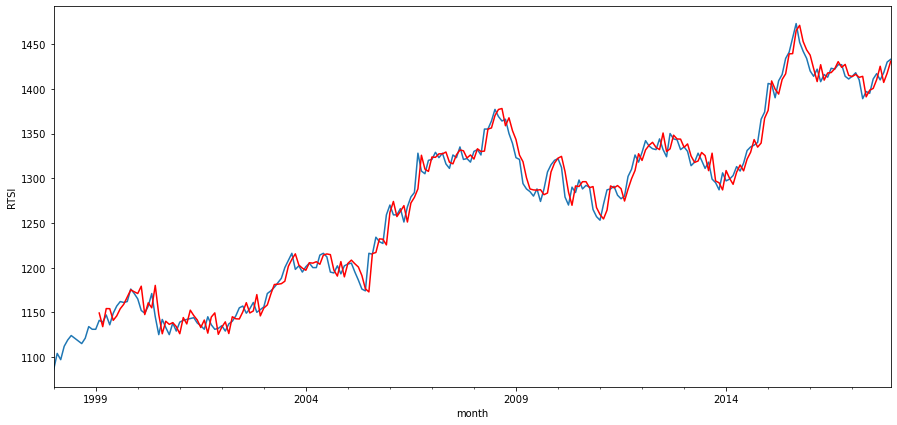

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.id.plot()
df.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

# Прогноз

Построим прогноз

## Прогнозирование

$$y_{t} = αˆ + φˆ_{1}y_{t−1} + ··· + φˆ_{p}y_{t−p} + ε_{t} + θˆ_{1}ε_{t−1} + ··· + θˆ_{q}ε_{t−q}$$

Заменяем t на T + 1:
$$yˆ_{T+1|T} = αˆ + φˆ_{1}y_{T} + ··· + φˆ_{p}y_{T+1−p} + ε_{T+1} + θˆ_{1}ε_{T} + ··· + θˆ_{q}ε_{T+1−q}$$

Заменяем будущие ошибки на нули:
$$yˆ_{T+1|T} = αˆ + φˆ_{1}y_{T} + ··· + φˆ_{p}y_{T+1−p} + θˆ_{1}ε_{T} + ··· + θˆ_{q}ε_{T+1−q}$$

Заменяем прошлые ошибки на остатки:
$$yˆ_{T+1|T} = αˆ + φˆ_{1}y_{T} + ··· + φˆ_{p}y_{T+1−p} + θˆ_{1}εˆ_{T} + ··· + θˆ_{q}εˆ_{T+1−q}$$

Если мы прогнозируем на момент времени T + 2, в формуле появляется
значение ряда из будущего:
$$yˆ_{T+2|T} = αˆ + φˆ_{1}y_{T+1} + ··· + φˆ_{p}y_{T+2−p} + θˆ_{1}εˆ_{T+1} + ··· + θˆ_{q}εˆ_{T+2−q}$$ 
Заменяем его на прогноз $$yˆ_{T+1|T}$$ .


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


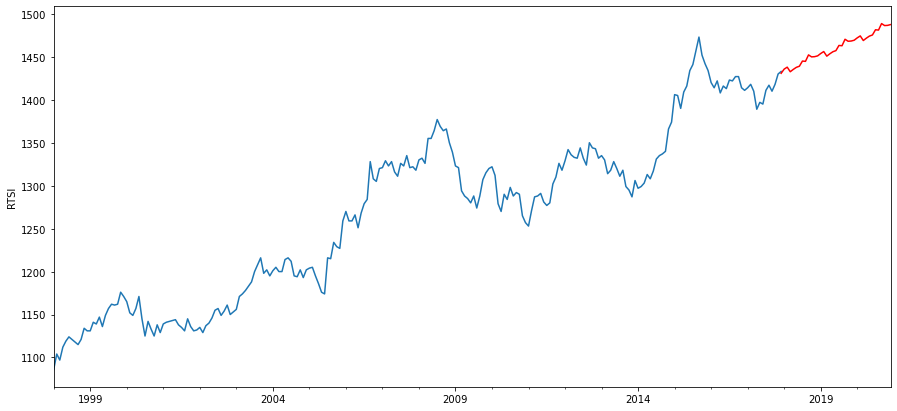

In [15]:
df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=239, end=500), lmbda)

plt.figure(figsize(15,7))
df2.id.plot()
df2.forecast.plot(color='r')
plt.ylabel('RTSI')
pylab.show()

Добавим данные за 2018-2020 года, чтобы сравнить с прогнозом

Терминология сезонной ARIMA

• Сезонная часть модели ARIMA равна
суммируется тремя дополнительными числами:

P = количество условий сезонной авторегрессии

D = количество сезонных различий

Q = количество условий сезонного скользящего среднего

• Полная модель называется
Модель «ARIMA (p, d, q) x (P, D, Q)»

Прогноз происходит с помощью функции predict

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


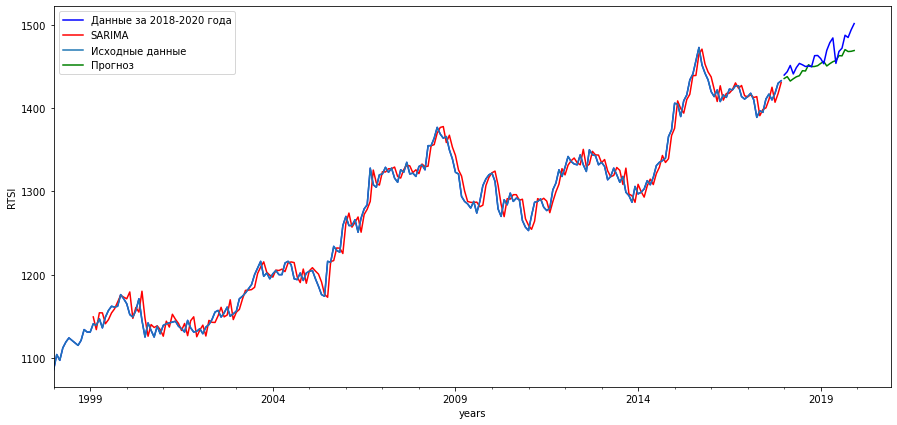

In [16]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda) #not predict

df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=240, end=263), lmbda)

df3 = pd.read_csv('C:/Users/user/Downloads/Practice-2020-master/Practice-2020-master/VASYA1.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.id.plot(color='blue')
df.model[13:].plot(color='red')
df2.id.plot()
df2.forecast.plot(color='green')
df3.id.plot(color='blue')
plt.legend(['Данные за 2018-2020 года',  'SARIMA', 'Исходные данные', 'Прогноз' ],)
plt.ylabel('RTSI')
plt.xlabel('years')
pylab.show()


#plt.plot(x, y1, 'o-r')
#plt.plot(x, y2, 'o-.g')
#plt.legend(['L1', 'L2'])

In [17]:
from sklearn import tree
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline 
from sklearn.metrics import mean_squared_error, r2_score
r2_score(df.id, df.model[:])
#r2_score(df2.forecast, df3.id)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 f

0.204968565173285

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.5991588430586476

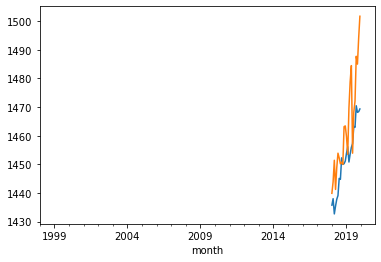

In [18]:
df2.forecast.plot()
df3.id.plot()
r2_score(df2.forecast[240:263],df3.id[:23])

In [19]:
#y = df.id
#X = df
#tscv = TimeSeriesSplit()
#print(tscv)
df2.forecast[240:264]

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2018-01-01    1435.716916
2018-02-01    1437.988842
2018-03-01    1432.658693
2018-04-01    1435.394313
2018-05-01    1437.767020
2018-06-01    1439.082663
2018-07-01    1445.079381
2018-08-01    1444.749292
2018-09-01    1452.262424
2018-10-01    1449.958303
2018-11-01    1450.200992
2018-12-01    1451.137586
2019-01-01    1453.863547
2019-02-01    1456.143025
2019-03-01    1450.795142
2019-04-01    1453.539870
2019-05-01    1455.920466
2019-06-01    1457.240480
2019-07-01    1463.257082
2019-08-01    1462.925900
2019-09-01    1470.463863
2019-10-01    1468.152136
2019-11-01    1468.395627
2019-12-01    1469.335313
Name: forecast, dtype: float64

In [20]:
import sys
import warnings

warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

%matplotlib inline


<Figure size 1080x504 with 0 Axes>

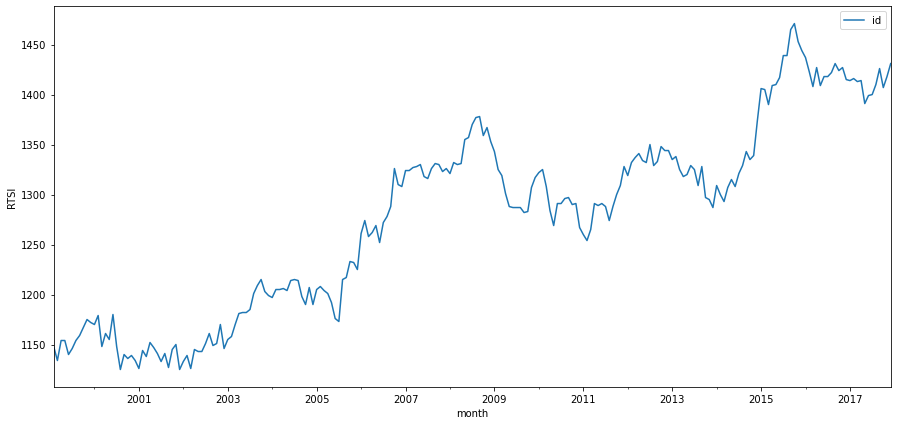

In [21]:

df6 = pd.read_csv('C:/Users/user/Desktop/event_data_train/VASYA6.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#C:\Users\user\Downloads
plt.figure(figsize(15,7))
df6.plot()
plt.ylabel('RTSI')
pylab.show()

In [22]:
#df5 = df.model[13:]
#df5.plot(color='red')


In [23]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
# Указать сгиб и выполнить разделение
tscv = TimeSeriesSplit(n_splits=4)
tscv.split(df)
#Find out no of observations in train and test sets
# Узнать количество наблюдений в тренировочных и тестовых наборах
i = 0
i=i+1
for train, test in tscv.split(df):
    
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=48
No of observations under test1=48
No of observations under train1=96
No of observations under test1=48
No of observations under train1=144
No of observations under test1=48
No of observations under train1=192
No of observations under test1=48


In [24]:
train1, test1 = df.iloc[0:60, 0], df.iloc[60:70, 0]
train2, test2 = df.iloc[70:120, 0], df.iloc[120:130, 0]
train3, test3 = df.iloc[130:180, 0], df.iloc[180:190, 0]
train4, test4 = df.iloc[190:230, 0], df.iloc[230:239, 0] 

In [25]:
class SARIMA():
    def __init__(self, Ps, Qs, ps, d, D):
        self.Qs = Qs
        self.ps = ps
        self.d = d
        self.D = D
        #self.qs = qs
        #self.Ps = Ps

# close method
def choose_SARIMA(self, X_train): # реализовать self
    from itertools import product
    parameters = product(self.ps, self.qs, self.Ps, self.Qs)
    parameters_list = list(parameters)
    len(parameters_list)
   
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    warnings.filterwarnings('default')
 
    return best_param, model 


def fit(self, X_train):
    d1, lmbda = stats.boxcox(pd.to_numeric(X_train))
    best_param, best_model = self.choose_SARIMAX(d1)  
    self_best_model = best_model
    self_best_param = best_param
    self.model = invoboxcox(best_motel.fittedvalues, lmbda)

def predict(start = b, end = n): # передавать сюда старт и энд
    return invboxcox(self_best_model.predict(start=b, end = n), lmbda)

UsageError: Line magic function `%%time` not found.


In [ ]:
model1

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

#df2['forecast'] = invboxcox(best_model.predict(start=240, end=262), lmbda)

model1=sm.tsa.statespace.SARIMAX(train1, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = invboxcox(best_model.predict(start=61, end=70), lmbda)
#model1.predict(start=test1.index[0], end=test1.index[-1])
r_squared1 = r2_score(test1, pred1)


model2=sm.tsa.statespace.SARIMAX(train2, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred2 = invboxcox(best_model.predict(start=121, end=130), lmbda) 
#model2.predict(start=test2.index[0], end=test2.index[-1])
r_squared2 = r2_score(test2, pred2)


model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred3 = invboxcox(best_model.predict(start=181, end=190), lmbda)
r_squared3 = r2_score(test3, pred3)

#model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], 2, param[1]), 
                                            #seasonal_order=(param[2], 2, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
#pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
#r_squared3 = r2_score(test3, pred3)

model4=sm.tsa.statespace.SARIMAX(train4, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred4 = invboxcox(best_model.predict(start=231, end=239), lmbda) 
#model4.predict(start=test4.index[0], end=test4.index[-1])
r_squared4 = r2_score(test4, pred4)

print("r_squared1: ", r_squared1)
print("r_squared2: ", r_squared2)
print("r_squared3: ", r_squared3)
print("r_squared4: ", r_squared4)



Overall_r_squared=round((r_squared1+r_squared2+r_squared3+r_squared4)/4,3)
print ("Overall r_squared:", Overall_r_squared) 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

#lmbda1 = stats.boxcox(pd.to_numeric(train1))
#lmbda2 = stats.boxcox(pd.to_numeric(train2))
#lmbda3 = stats.boxcox(pd.to_numeric(train3))
#lmbda4 = stats.boxcox(pd.to_numeric(train4))

#df2['forecast'] = invboxcox(best_model.predict(start=240, end=262), lmbda)

model1=sm.tsa.statespace.SARIMAX(train1, order=(param[0], 2, param[1]), 
                                            seasonal_order=(param[2], 2, param[3], 12)).fit(disp=-1)
pred1 = stats.boxcox(train1.predict(start=61, end=70), lmbda)
r_squared1 = r2_score(test1, pred1)



model2=sm.tsa.statespace.SARIMAX(train2, order=(param[1], 2, param[2]), 
                                            seasonal_order=(param[2], 2, param[3], 12)).fit(disp=-1)
pred2 = stats.boxcox(train2.predict(start=121, end=130), lmbda) 
r_squared2 = r2_score(test2, pred2)




model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], 1, param[1]), 
                                            seasonal_order=(param[2], 1, param[3], 12)).fit(disp=-1)
pred3 = stats.boxcox(train3.predict(start=180, end=190), lmbda)
r_squared3 = r2_score(test3, pred3)




model4=sm.tsa.statespace.SARIMAX(train4, order=(param[0], 2, param[2]), 
                                            seasonal_order=(param[2], 2, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred4 = stats.boxcox(train4.predict(start=230, end=239), lmbda) 
#model4.predict(start=test4.index[0], end=test4.index[-1])
r_squared4 = r2_score(test4, pred4)

print("r_squared1: ", r_squared1)
print("r_squared2: ", r_squared2)
print("r_squared3: ", r_squared3)
print("r_squared4: ", r_squared4)



Overall_r_squared=round((r_squared1+r_squared2+r_squared3+r_squared4)/4,3)
print ("Overall r_squared:", Overall_r_squared) 

In [ ]:
train1
#train2
train3

In [ ]:
import matplotlib.pyplot as plt
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("month")
plt.ylabel("id")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1', color='red')
plt.plot(test1.index, test1, label='Test1') #, color='orange')
plt.plot(pred1.index, pred1, label='prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='green', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2', color='blue')
plt.plot(test2.index, test2, label='Test2')#, color='brown')
plt.plot(pred2.index, pred2, label='prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='red', alpha=0.2)

#Third fold
plt.plot(train3.index, train3, label='Train3', color='blue')
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='blue', alpha=0.3)

#Third fold
plt.plot(train3.index, train3, label='Train3', color='blue')
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='blue', alpha=0.3)

#Third fold
plt.plot(train4.index, train4, label='Train4', color='blue')
plt.plot(test4.index, test4, label='Test4')
plt.plot(pred4.index, pred4, label='prediction4')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test4.index[0], test4.index[-1],  facecolor='blue', alpha=0.4)

#plt.plot(train4.index, train4, label='Train4')

In [ ]:
model1


In [ ]:
#df2.id.plot()
#df2.forecast.plot(color='green')

In [ ]:
#df7 = pd.read_csv('C:/Users/user/Desktop/VASYA7.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df7.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [ ]:
#Fit a model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

#model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=3).fit()
#pred = model.predict(start=test.index[0], end=test.index[-1])
#r_squared = r2_score(test, pred)
#print('r_square_value :',r_squared)


In [ ]:
#df11 = pd.read_csv('C:/Users/user/Desktop/VASYA11.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df11.id.plot()
#plt.ylabel('RTSI')
#pylab.show()

## Коэффициент детерминации для тестовой выборки (test)

In [ ]:
#from sklearn.metrics import r2_score
#y_true = df11
#y_pred = df7
#r2_score(y_true, y_pred)

In [ ]:
#y_true.plot()
#y_pred.plot()

## Коэффициент детерминации для тренировочной выборки (train)

In [ ]:
#true 
#df41 = pd.read_csv('C:/Users/user/Desktop/VASYA41.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df41.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [ ]:
#pred
#df61 = pd.read_csv('C:/Users/user/Desktop/VASYA61.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#df61.plot()
#plt.ylabel('RTSI')
#pylab.show()

In [ ]:
#df41.plot()
#df61.plot()

In [ ]:
#print(df41.shape)
#print(df61.shape)

In [ ]:
#from sklearn.metrics import r2_score
#y_true = df41
#y_pred = df61
#r2_score(y_true, y_pred)

In [ ]:
df

In [ ]:
s_obj = SARIMA(Ps, Qs, ps, d, D)#Ps, Qs, ps, qs) self, Ps, Qs, ps, d, D (Ps, Qs, ps, d, D)

#s_obj.fit(train1)
m_ind = len(train1)
y_pr1 = s_obj.predict(m_ind, m_ind + len(test1))

#s_obj.fit(train2)
m_ind = len(train2)
y_pr2 = s_obj.predict(m_ind, m_ind + len(test2))

#s_obj.fit(train3)
m_ind = len(train3)
y_pr3 = s_obj.predict(m_ind, m_ind + len(test3))

v1 = r2_score(y_pr1, y_test1)
v2 = r2_score(y_pr2, y_test2)
v3 = r2_score(y_pr3, y_test3)

#s_obj.predict(len(df_test1), len(df_test1) * 2)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [ ]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [ ]:
train

In [ ]:
class SARIMA():
    def SARIMA (self):
        
    def init(ps, qs, Ps, Qs): #self, Ps, Qs, ps, d, D):
        Qs = Qs
        ps = ps
        d = d
        D = D
        #self.qs = qs
        #self.Ps = Ps
        
    def choose_SARIMA(self, train): # реализовать self
        from itertools import product
        parameters = product(self.ps, self.qs, self.Ps, self.Qs)
        parameters_list = list(parameters)
        len(parameters_list)
        
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore') 

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(X_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    warnings.filterwarnings('default')
 
    return best_param, model 
        
    def fit(self, X_train):
        d1, lmbda = stats.boxcox(pd.to_numeric(X_train))
        best_param, best_model = self.choose_SARIMAX(d1)    
        self_best_model = best_model
        self_best_param = best_param
        self.model = invoboxcox(best_motel.fittedvalues, lmbda)
        
    def predict(self, start = b, end = n): # передавать сюда старт и энд
        d1, lmbda = stats.boxcox(pd.to_numeric(X_train))
        best_param, best_model = self.choose_SARIMAX(d1)    
        self_best_model = best_model
        self_best_param = best_param
        self.model = invoboxcox(best_motel.fittedvalues, lmbda)
        return invboxcox(self_best_model.predict(start=b, end = n), lmbda)

In [ ]:
class SARIMA():
    def __init__(self, Ps, Qs, ps, d, D):
        self.Qs = Qs
        self.ps = ps
        self.d = d
        self.D = D
        #self.qs = qs
        #self.Ps = Ps

# close method
def choose_SARIMA(self, X_train): # реализовать self
    from itertools import product
    parameters = product(self.ps, self.qs, self.Ps, self.Qs)
    parameters_list = list(parameters)
    len(parameters_list)
   
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(X_train, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    warnings.filterwarnings('default')
 
    return best_param, model 


def fit(self, X_train):
    d1, lmbda = stats.boxcox(pd.to_numeric(X_train))
    best_param, best_model = self.choose_SARIMAX(d1)  
    self_best_model = best_model
    self_best_param = best_param
    self.model = invoboxcox(best_motel.fittedvalues, lmbda)

def predict(start = b, end = n): # передавать сюда старт и энд
    return invboxcox(self_best_model.predict(start=b, end = n), lmbda)



In [ ]:
s_obj = SARIMA(Ps, Qs, ps, d, D)#, fit)Ps, Qs, ps, qs)

s_obj.fit(train1)
m_ind = len(train1)
y_pr1 = s_obj.predict(m_ind, m_ind + len(df_test1))

s_obj.fit(train2)
m_ind = len(train2)
y_pr2 = s_obj.predict(m_ind, m_ind + len(df_test2))

s_obj.fit(train3)
m_ind = len(train3)
y_pr3 = s_obj.predict(m_ind, m_ind + len(df_test3))

v1 = r2_score(y_pr1, y_test1)
v2 = r2_score(y_pr2, y_test2)
v3 = r2_score(y_pr3, y_test3)


In [ ]:
df.id.plot()

In [ ]:
train3.plot()
test3.plot()
pred3.plot()

In [ ]:
df.id.plot()
train1.plot()
train2.plot()
train3.plot()


In [ ]:
df.id.plot()

train1.plot()
train2.plot()
train3.plot()

test1.plot()
test2.plot()
test3.plot()

pred1.plot()
pred2.plot()
pred3.plot()

In [ ]:
sm.tsa.seasonal_decompose(train1,period=12).plot()
def invboxcox(y,lmbda): # обратная функция Бокса-Кокса
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train1)[1])

In [ ]:
train3.plot()
test3.plot()

In [ ]:
train2.plot()
test2.plot()

In [ ]:
train1.plot()
test1.plot()

In [ ]:
test1.plot()
pred1.plot()

In [ ]:
train3.plot()
test3.plot()
pred3.plot()

In [ ]:
df.id.plot()
df.model[13:].plot(color='r')

In [ ]:
r2_score(df.id, df.model[13:])

In [ ]:
pred1.plot()
pred2.plot()
pred3.plot()

$$r_{τ} = \frac{\sum_{t=1}^{T-τ}(y_{t} − y^-)(y_{t+τ} − y^-)}{\sum_{t=1}^{T}(y_{t} − y^-)^2}.$$
H - гильбертово пространство
L(U) = f
$$H_{n}$$ - конечномерное пространство
$$r_{n} = L(u_{n}) - f$$ 
$$||r_{n}|| = min$$
$$ Надо выбрать базис l_{1}...l_{n} $$
$$u_{n} = {\sum_{k=1}^{n}α_{k}l_{k}}$$



H - гильбертово пространство

L(U) = f

конечномерное пространство:
$$H_{n}$$   

ищем
$$u_{n}∈H_{n}$$  

невязка $$r_{n} = L(u_{n}) - f$$ 

приближенное решение: $$ r_{n} -> 0$$ при увеличении пространства $$H_{n}$$

$$||r_{n}|| = min$$
Надо выбрать базис: $$  l_{1}...l_{n} $$
$$u_{n} = {\sum_{k=1}^{n}a_{k}l_{k}}$$

$$L(u_{n}) = Ф(a_{1}...a_{n}) $$

$$ (Ф(a_{1}...a_{n})-f,Ф(a_{1}...a_{n})-f) = min $$

$$ ∫(Ф(a_{1}a_{2}...a_{n})-f)^2dx_{1}...dx_{k}$$

$$r_{τ} = \frac{\sum_{t=1}^{T-τ}(y_{t} − y^-)(y_{t+τ} −   y^-)}{\sum_{t=1}^{T}(y_{t} − y^-)^2}.$$

